# HW6 Support Vector Machine

by Ruijie Rao

*Note: This report is not only created for assignment purpose, but also for references and revision purpose in my future career. As a result, an amount of code and explanations are necessary to be included.*

In [1]:
import pandas as pd
import numpy as np
import cvxopt as cvx
import matplotlib.pyplot as plt

## Data Importation

In [2]:
with open("linsep.txt", "r") as file:
    content = file.readlines()
linsep_data = np.array([line.strip("\n").split(",") for line in content] ).astype(float)

In [3]:
with open("nonlinsep.txt", "r") as file:
    content = file.readlines()
nonlinsep_data = np.array([line.strip("\n").split(",") for line in content] ).astype(float)

## Data Structure

X is a numpy array of 2-dimensional coordinates. y is a numpy array of 1-dimensional labels: -1, 1. According to my observation, I will be using Gaussian RBF as the Kernel.

## Linear SVM

According to Lecture Notes:
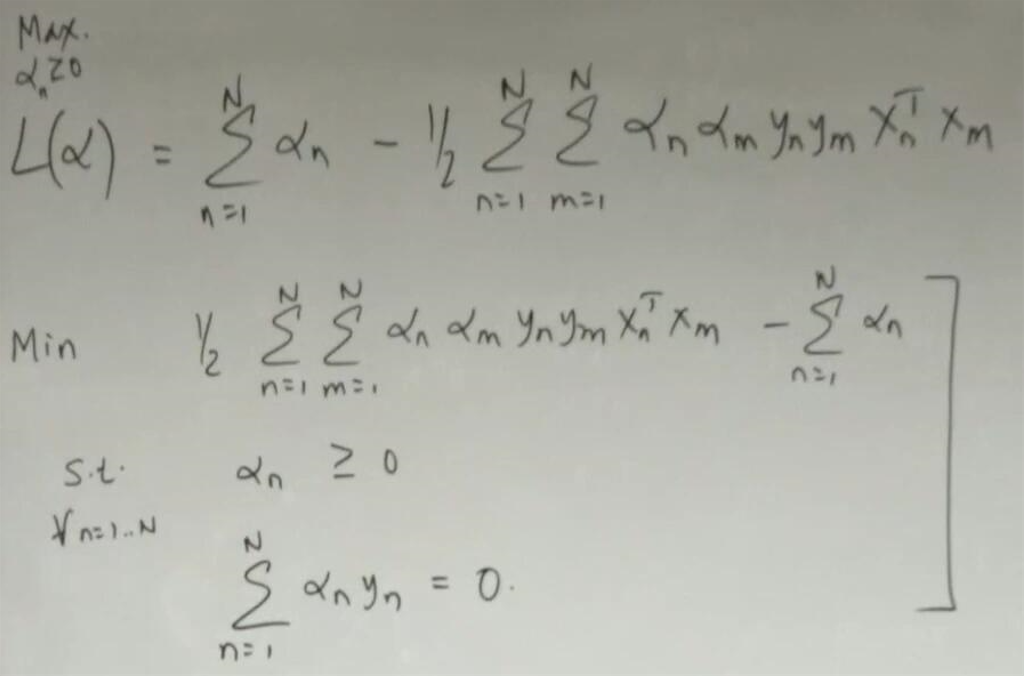

The goal of this algorithm is to find the fattest linear margin line that seperates points of different labels (-1, +1). In order to do this, we will construct a quadratic optimization problem and solve its dual problem using a QPP solver.

### Optimization Problem

$$
\min_{a} \frac{1}{2}\sum^{N}_{n=1}\sum^{N}_{m=1} \alpha_n\alpha_my_n y_m x_n^T x_m - \sum^{N}_{n=1}\alpha_n \\
s.t. \alpha \ge 0\\
\sum^{N}_{n=1}a_n y_n = 0
$$

In order to solve it using a solver, need to organize the problem into specific form:
$$
\min \frac{1}{2} x^{T}Px+q^{T}x \\
s.t. Gx \lt h \\
Ax = b
$$

In [70]:
X = linsep_data[:,:-1]
y = linsep_data[:,-1].reshape([-1,1])
m = X.shape[0]
n = X.shape[1]

P = cvx.matrix((X*y)@(X*y).T) #mxm
q = cvx.matrix(-np.ones((m, 1))) # mx1, transpose to 1xm, qTa = -sum(a)
G = cvx.matrix(-np.eye(m)) # mxm negative identity matrix, Ga = -a, -a<=0|a>=0
h = cvx.matrix(np.zeros((m, 1))) #mx1 zeros
A = cvx.matrix(y.T) #1xm
b = cvx.matrix(np.zeros(1)) #sum to 1 zeros

In [71]:
linsep_solver = cvx.solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0: -2.0636e+01 -4.3905e+01  3e+02  2e+01  2e+00
 1: -2.2372e+01 -3.7202e+01  9e+01  5e+00  5e-01
 2: -2.3112e+01 -3.8857e+01  5e+01  2e+00  2e-01
 3: -2.8318e+01 -3.3963e+01  1e+01  4e-01  4e-02
 4: -3.2264e+01 -3.3927e+01  2e+00  1e-02  1e-03
 5: -3.3568e+01 -3.3764e+01  2e-01  1e-03  1e-04
 6: -3.3737e+01 -3.3739e+01  2e-03  1e-05  1e-06
 7: -3.3739e+01 -3.3739e+01  2e-05  1e-07  1e-08
 8: -3.3739e+01 -3.3739e+01  2e-07  1e-09  1e-10
Optimal solution found.


### Alpha Solution

In [72]:
alpha = np.array(linsep_solver['x'])

### $w$ and $\beta$ Retrieval

$$
w = \sum^{N}_{n=1}a_n y_n x_n \\
bias = y_m-w^T x_m
$$
where:$$a_m>0$$

In [78]:
w = (alpha*y).T@X#1xn
idx = np.argmax(alpha)
bias = y[idx]-X[idx].reshape(1,-1)@w.T #1

In [85]:
w = np.array([[7.25005616,-3.86188932]])
bias = -0.10698729

In [86]:
result = ((X@w.T+bias)>=0)*1.

### Test

Data Plotted

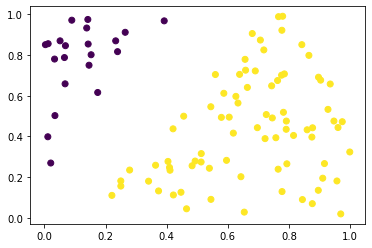

In [52]:
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

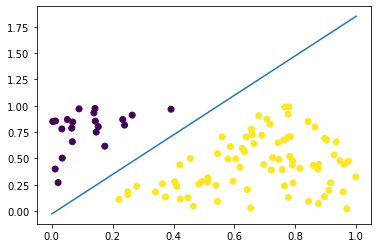

In [87]:
plt.scatter(X[:,0],X[:,1],c=result)
x1 = np.linspace(0,1,100)
x2 = ((-w.flatten()[0]*x1-bias)/w.flatten()[-1]).reshape(100,)
plt.plot(x1,x2)
plt.show()

## Non-Linear SVM

According to Lecture Notes:
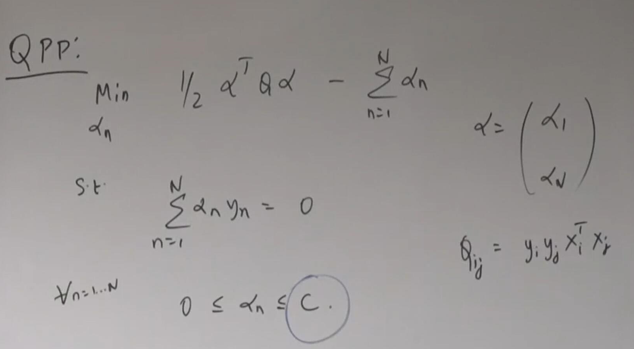

The goal of this algorithm is to find the fattest Non-linear margin line that seperates points of different labels (-1, +1) but also tolerates outliers. In order to do this, we will construct a quadratic optimization problem and solve its dual problem using a QPP solver.

### Optimization Problem

$$
\min_{a} \frac{1}{2}\sum^{N}_{n=1}\sum^{N}_{m=1} \alpha_n\alpha_my_n y_m x_n^T x_m - \sum^{N}_{n=1}\alpha_n \\
s.t. 0\le \alpha, \\
\alpha \le C, \\
\sum^{N}_{n=1}a_n y_n = 0
$$

In order to solve it using a solver, need to organize the problem into specific form:
$$
\min \frac{1}{2} x^{T}Px+q^{T}x \\
s.t. Gx \lt h \\
Ax = b
$$

$G$ and $h$ needs to be adjusted to fit 2 conditions. C is the weight of slackness.

In [4]:
def gaussian_kernel(x1, x2, sigma=5.0):
    return np.exp(-np.linalg.norm(x1-x2)**2 / (2 * (sigma ** 2)))

In [13]:
X = nonlinsep_data[:,:-1]
y = nonlinsep_data[:,-1].reshape([-1,1])
m = X.shape[0]
n = X.shape[1]
C = 10

K = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        K[i,j] = gaussian_kernel(X[i], X[j])

P = cvx.matrix(K*(y@y.T)) #mxm
q = cvx.matrix(-np.ones((m, 1))) # mx1, transpose to 1xm, qTa = -sum(a)
G = cvx.matrix(np.vstack((-np.eye(m),np.eye(m)))) # upper half:mxm negative identity matrix, Ga = -a, -a<=0|a>=0, lower half:mxm identity matrix, Ga = a
h = cvx.matrix(np.vstack((np.zeros((m, 1)),np.ones((m, 1))*C))) #mx1 zeros
A = cvx.matrix(y.T) #1xm
b = cvx.matrix(np.zeros(1)) #sum to 1 zeros

In [14]:
nonlinsep_solver = cvx.solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0:  2.7918e+02 -3.0820e+03  5e+03  2e-01  3e-15
 1:  9.9413e+01 -3.6872e+02  5e+02  1e-02  2e-15
 2: -6.6638e-01 -1.3162e+02  1e+02  2e-03  2e-15
 3: -3.6845e+01 -7.3607e+01  4e+01  3e-04  2e-15
 4: -4.7423e+01 -5.6462e+01  9e+00  5e-05  2e-15
 5: -5.0167e+01 -5.2057e+01  2e+00  5e-07  1e-15
 6: -5.0683e+01 -5.0985e+01  3e-01  6e-08  2e-15
 7: -5.0779e+01 -5.0813e+01  3e-02  6e-09  2e-15
 8: -5.0792e+01 -5.0793e+01  1e-03  1e-10  2e-15
 9: -5.0793e+01 -5.0793e+01  4e-05  1e-12  2e-15
Optimal solution found.


### Alpha Solution

In [69]:
alpha = np.array(nonlinsep_solver['x'])

### $w$ and $\beta$ Retrieval

$$
w = \sum^{N}_{n=1}a_n y_n x_n \\
\beta = C-\alpha \\
b = y_m-w^T x_m = y_m-\sum^{N}_{n=1}a_n y_n x_n x_m = y_m-\sum^{N}_{n=1}a_n y_n K(x_n,x_m)
$$
where:$$a_m>0$$

In [27]:
idx = (alpha>1e-6).flatten()
ai = alpha[idx]
Xi = X[idx]
yi = y[idx]

In [36]:
bias = yi[0]-(ai*yi).T@np.array([gaussian_kernel(x,Xi[0]) for x in Xi])

$$
f(x) = w^T h(x) + b = \sum_{i=0}^n \alpha_i y_i \langle h(x_i), h(x) \rangle
$$

In [54]:
result = np.array([(ai*yi).T@np.array([gaussian_kernel(xi,xj) for xi in Xi]) for xj in X])+bias

In [66]:
result = (result>=0)*1.

Original Labeled Data:

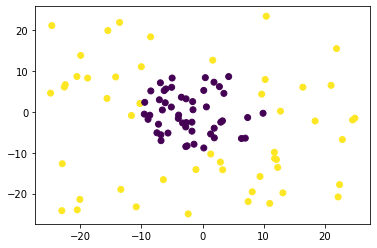

In [5]:
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

SVM Seperated Labeled Data:

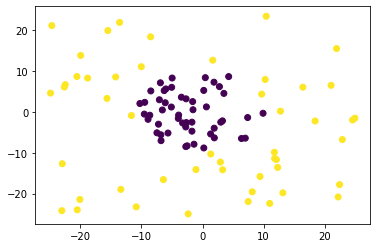

In [67]:
plt.scatter(X[:,0],X[:,1],c=result)
plt.show()

## Challenges and Optimizations

**Challenge**: 
1. First time using CVXOPT Library in python is a challenge for me. Have read through some guides and examples before getting hold of its power.
2. Linear Seperable SVM is easy using the solver. However, soft margin requires some changes made to the process, and implementing Kernel is the biggest challenge for me. The lecture note did not talk about the formula of implementing kernel in predicting phase, thus I searched for it and was finally able to transform the formula from $wx+b$ to $\sum_{i=0}^n \alpha_i y_i \langle h(x_i), h(x) \rangle$

**Optimization**:
1. Instead of codes lying everywhere, I have gathered both linear and non linear codes into one single class called SVM in my py file. The object can be called and used to fit and predict any data using any input kernel with different values of C.